# Coffea Analysis of a NanoAOD MC dataset for CMS Run II (2016)

## Imports & reading

In [261]:
# imports

import uproot
import numpy as np
import awkward as ak
import hist
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use("CMS")
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

In [262]:
# read the file

events = NanoEventsFactory.from_root('GluGluToH_HToJPsiG_JPsiToMuMu_TuneCP5_13TeV-madgraph-pythia8_RunIISummer20UL16_Skim.root', schemaclass = NanoAODSchema.v7, treepath='Events').events()

/usr/local/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  warnings.warn(
/usr/local/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/usr/local/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(
/usr/local/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for GenVisTau_genPartIdxMother => GenPart
  warnings.warn(
/usr/local/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:200: RuntimeWarning: Missing cross-reference target for Jet_genJetIdx => GenJet
  warnings.warn(


In [290]:
# show the available contents for each of the events

events.fields

['is2018',
 'lheWeight',
 'iPhoton',
 'nCleanMuon',
 'GenPart',
 'PSWeight',
 'SoftActivityJetNjets10',
 'isMC',
 'LHEPart',
 'is2016',
 'GenMET',
 'luminosityBlock',
 'H',
 'Jet',
 'photonWeightDown',
 'eventJPsiWeightLumi',
 'maxMuonPfSubIso',
 'SoftActivityJetHT10',
 'iMuon1',
 'stitchWeight',
 'isDoubleMuonTrigger',
 'eventMuonEGWeightLumi',
 'is2017',
 'leptonWeight',
 'maxMuonPfIso',
 'photonMetDPhi',
 'LHEWeight',
 'Muon12',
 'LHE',
 'genWeight',
 'SoftActivityJet',
 'ChsMET',
 'qcdnnloWeight',
 'SoftActivityJetHT',
 'nCleanForwardJet',
 'triggerJPsiWeight',
 'LowPtElectron',
 'Tau',
 'nCleanCentralJet',
 'SoftActivityJetHT2',
 'trCentr',
 'nCleanPhoton',
 'nCleanBTagJet',
 'genTtbarId',
 'DeepMETResponseTune',
 'isSingleMuonTrigger',
 'triggerWeight',
 'cosTheta1',
 'triggerWeightUp',
 'phi1',
 'genCosThetaStar',
 'PV',
 'isJPsiTrigger',
 'HT30',
 'Muon1',
 'IsoTrack',
 'genCosTheta1',
 'qcdnloWeight',
 'Photon',
 'event',
 'DeepMETResolutionTune',
 'minMuonPfIso',
 'GenVtx',
 

## Filtering the events

Selection cuts:
* Muons:
    * $ p_{T} > 18 \textrm{ }\mathrm{GeV}$
    * $|\eta| < 2.4$
* Gammas: $ p_{T} > 30 \textrm{ }\mathrm{GeV}$


In [291]:
muon_pt_cut = 18
muon_eta_cut = 2.4
photon_pt_cut = 30

In [303]:
# declare the filters required for the events

# muon filters
muon_filters = (events.Muon.pt > muon_pt_cut) & (abs(events.Muon.eta) < muon_eta_cut)
muon_filters = muon_filters & (events.Muon.pt < 10000) # somehow there is an event with a 10400 GeV pT muon

# photon filters
photon_filters = (events.Photon.pt > photon_pt_cut)


event_filters = ak.any(photon_filters, axis = -1) & ak.any(muon_filters, axis = -1) # the axis = -1 here allows us to go event by event
                                                                                    # so if theres AT LEAST a muon / photon if an event
                                                                                    # that satisfies the required cut
                                                                                    # then the event is kept

selected_events = events[event_filters] # these are the events that satisfy every requirement
print("The events that satisfy all the requirements are the %.1f%%" % (len(selected_events) / len(events) * 100))

The events that satisfy all the requirements are the 91.4%


In [313]:
# apply the filters

selected_muons = events.Muon[muon_filters]
selected_photons = events.Photon[photon_filters]

In [314]:
# info on the cuts efficiency

print("A total of", sum(ak.num(selected_muons)), "out of", sum(ak.num(events.Muon)), "muons (%.1f%%) passed the cuts." % (sum(ak.num(selected_muons))/sum(ak.num(events.Muon)) * 100))

A total of 735 out of 1134 muons (64.8%) passed the cuts.


## Plots

### Muon $p_{T}$

/var/folders/nv/28ksfhj10wz9h413w7pr82sc0000gn/T/ipykernel_35337/4043144075.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


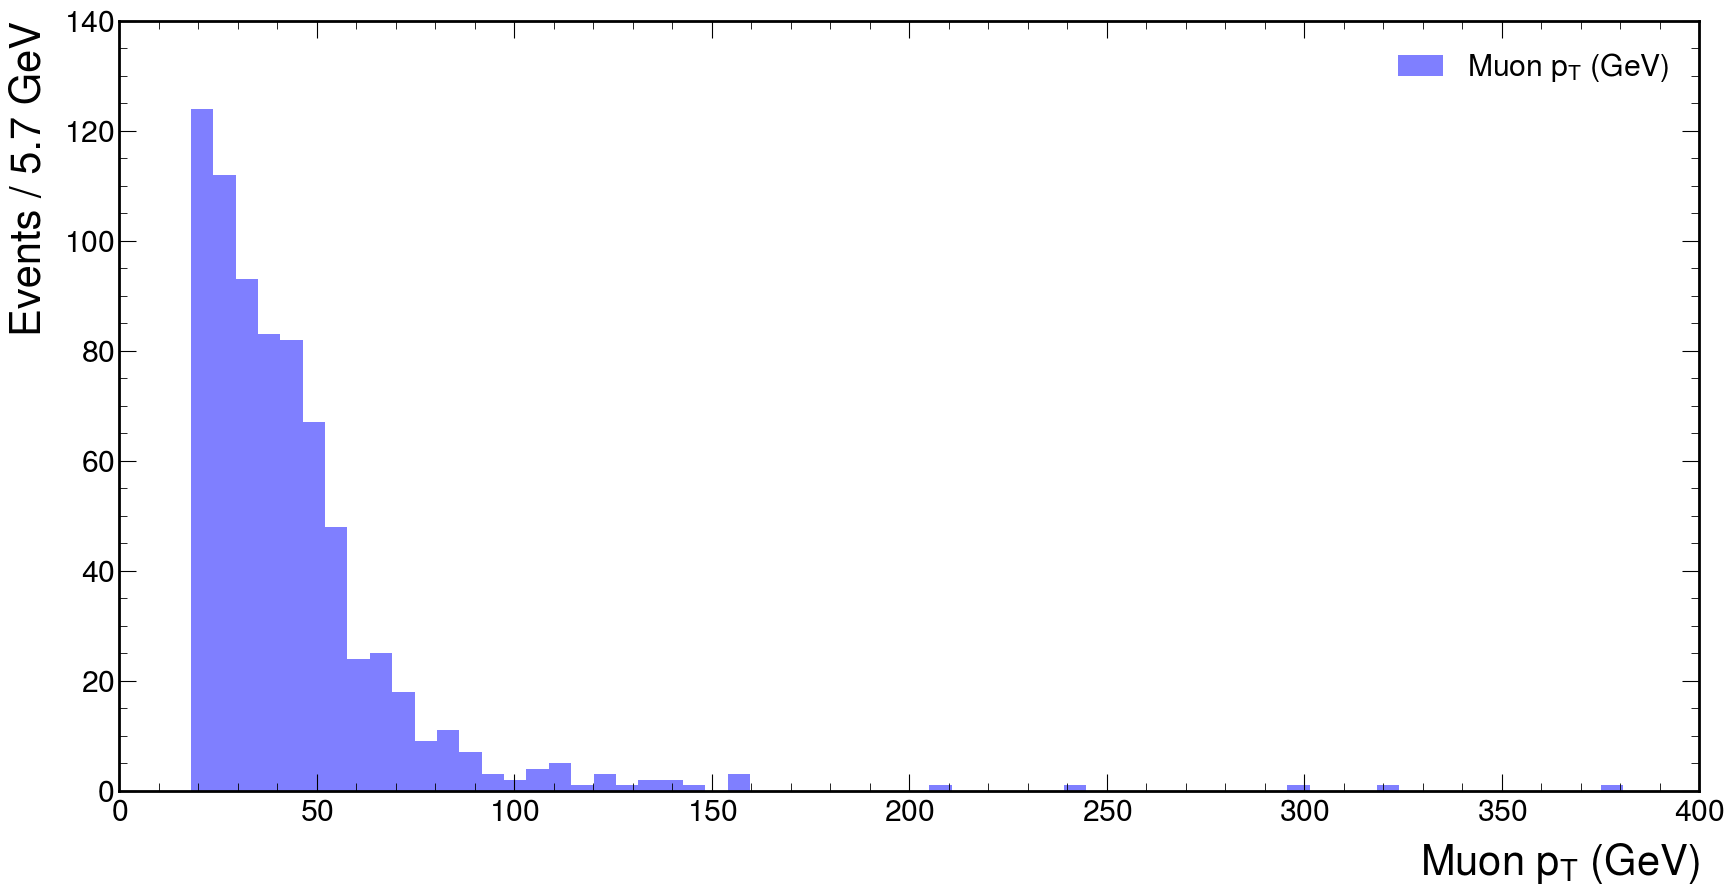

In [315]:
pt_min = 0
pt_max = 400
nbins = 64

counts, bins = np.histogram(ak.flatten(selected_muons.pt, axis = None), nbins) # we flatten the ak-array to have all the values in a 1D-array
                                                                               # we also compute the bins heights (counts) 
                                                                               # and the bin edges (bins)
                                                                               # for a given number of bins (nbins)

width = bins[1] - bins[0]


fig, ax = plt.subplots(figsize=(20, 10))
hep.histplot(
    counts,
    bins = bins,
    histtype = "fill",
    color = "b",
    alpha = 0.5,
    edgecolor = "red",
    label = r"Muon $p_{T}$ (GeV)",
    ax = ax,
)
ax.set_xlabel("Muon $p_{T}$ (GeV)", fontsize = 30)
ax.set_ylabel("Events / %.1f GeV" % width, fontsize = 30)
ax.set_xlim(pt_min, pt_max)
ax.legend()

### Photon $p_{T}$

/var/folders/nv/28ksfhj10wz9h413w7pr82sc0000gn/T/ipykernel_35337/116511354.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


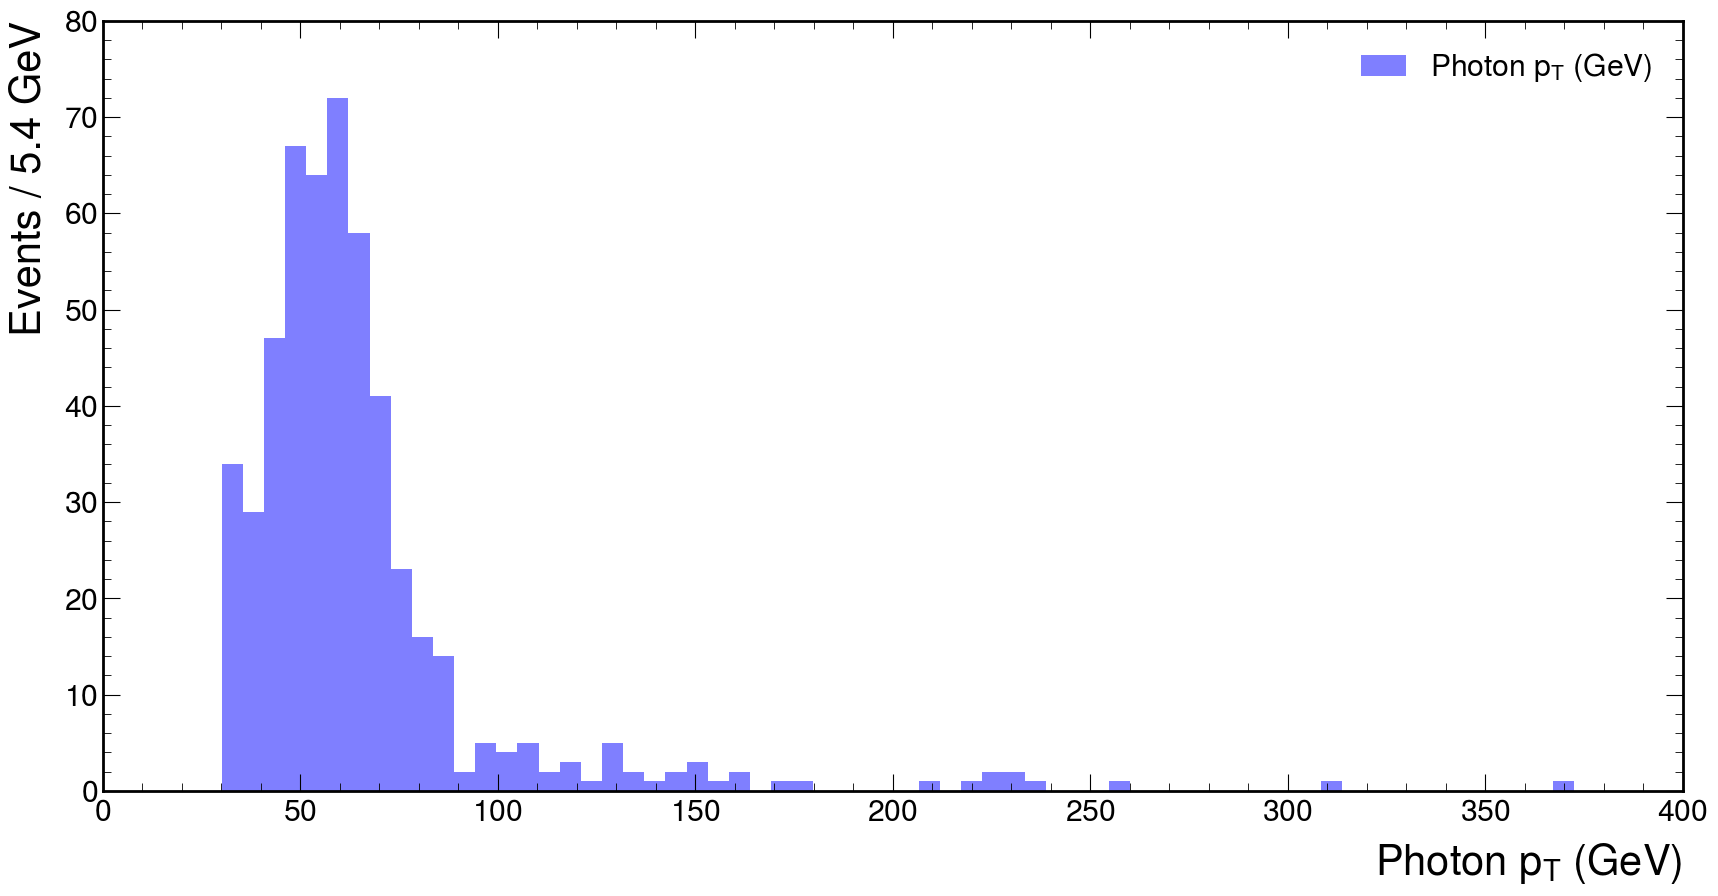

In [322]:
pt_min = 0
pt_max = 400
nbins = 64

counts, bins = np.histogram(ak.flatten(selected_photons.pt, axis = None), nbins) # we flatten the ak-array to have all the values in a 1D-array
                                                                               # we also compute the bins heights (counts) 
                                                                               # and the bin edges (bins)
                                                                               # for a given number of bins (nbins)

width = bins[1] - bins[0]


fig, ax = plt.subplots(figsize=(20, 10))
hep.histplot(
    counts,
    bins = bins,
    histtype = "fill",
    color = "b",
    alpha = 0.5,
    edgecolor = "red",
    label = r"Photon $p_{T}$ (GeV)",
    ax = ax,
)
ax.set_xlabel("Photon $p_{T}$ (GeV)", fontsize = 30)
ax.set_ylabel("Events / %.1f GeV" % width, fontsize = 30)
ax.set_xlim(pt_min, pt_max)
ax.legend()

### Photon quality

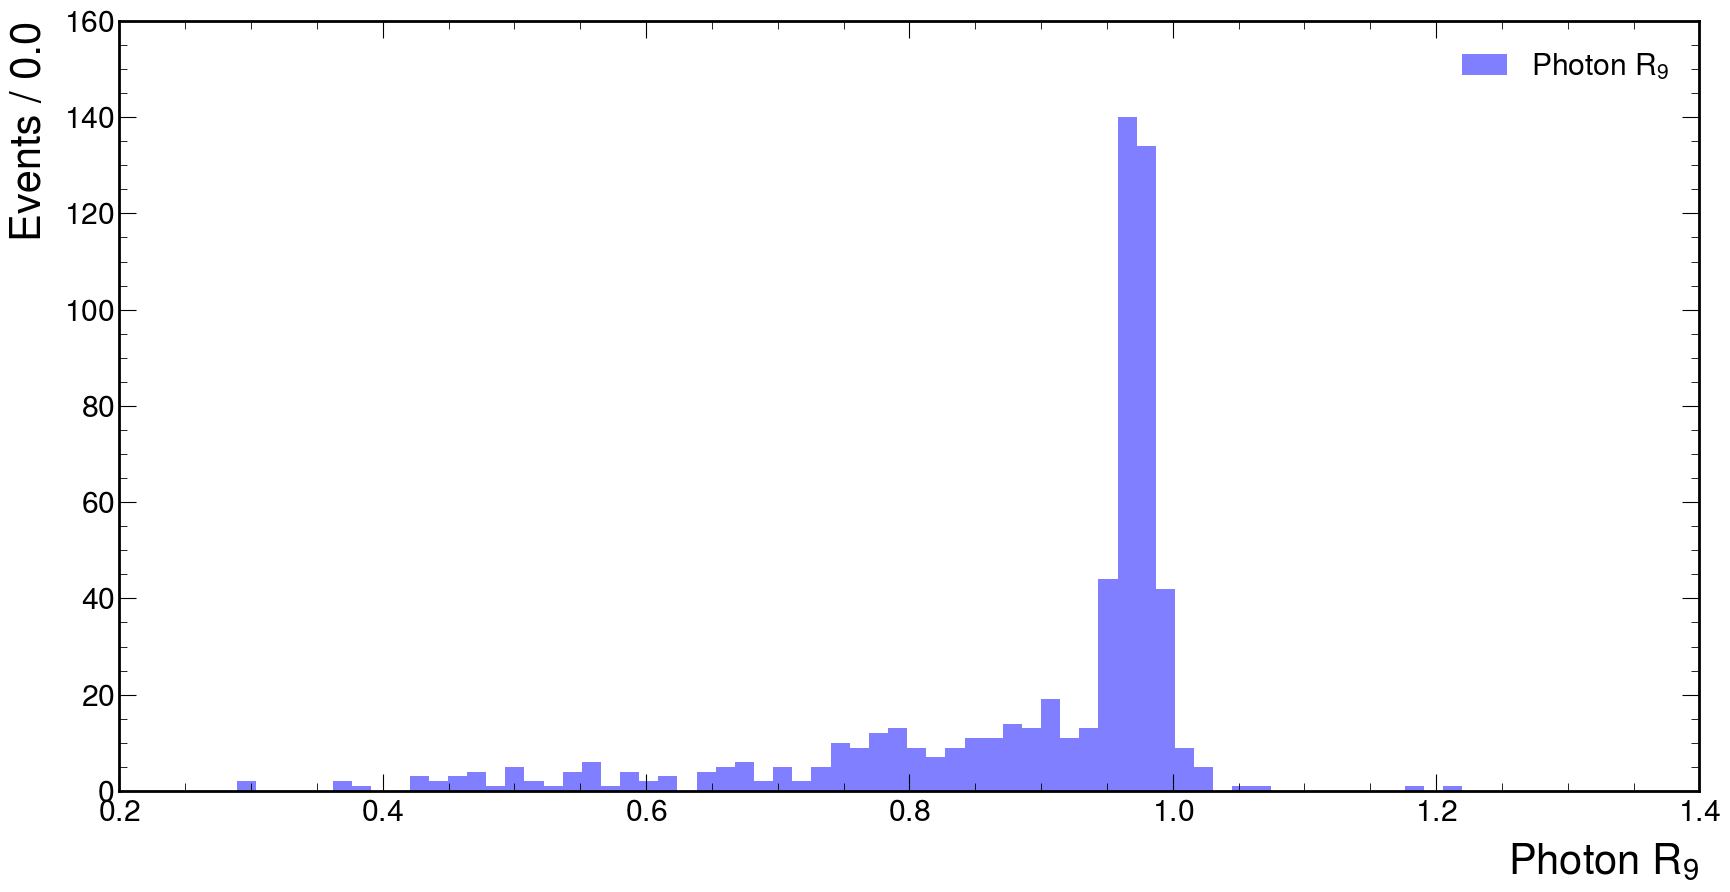

In [324]:
nbins = 64

counts, bins = np.histogram(ak.flatten(events.Photon.r9, axis = None), nbins) # we flatten the ak-array to have all the values in a 1D-array
                                                                                 # we also compute the bins heights (counts) 
                                                                                 # and the bin edges (bins)
                                                                                 # for a given number of bins (nbins)

width = bins[1] - bins[0]


fig, ax = plt.subplots(figsize=(20, 10))
hep.histplot(
    counts,
    bins = bins,
    histtype = "fill",
    color = "b",
    alpha = 0.5,
    edgecolor = "red",
    label = r"Photon $R_{9}$",
    ax = ax,
)
ax.set_xlabel("Photon $R_{9}$", fontsize = 30)
ax.set_ylabel("Events / %.1f" % width, fontsize = 30)
#ax.set_xlim(pt_min, pt_max)
ax.legend()

### Invariant mass

## Signal efficiency: efficiency of the trigger path (HLT_Mu17_Photon30) with respect to the desired signal

In [268]:
print("The number of events that passed the logical trigger is:", ak.sum(events.HLT.Mu17_Photon30_CaloIdL_L1ISO, axis = 0))

The number of events that passed the logical trigger is: 420


In [269]:
num = 0
for i in range(len(events.Muon[events.HLT.Mu17_Photon30_CaloIdL_L1ISO].pt)):
    if any(events.Muon[events.HLT.Mu17_Photon30_CaloIdL_L1ISO].pt[i] > muon_pt_cut) & any(events.Photon[events.HLT.Mu17_Photon30_CaloIdL_L1ISO].pt[i] > photon_pt_cut):
        num += 1
    
print("The number of events that passed the logical trigger AND the selection cuts is:", num)

The number of events that passed the logical trigger AND the selection cuts is: 418


In [270]:
den = 0
for i in range(len(events.Muon.pt)):
    if any(events.Muon.pt[i] > muon_pt_cut) & any(events.Photon.pt[i] > photon_pt_cut):
        den += 1
print("The number of events that passed the selection cuts is:", den)

The number of events that passed the selection cuts is: 476


In [271]:
trig_eff = num / den * 100
print("The trigger efficiency is %.1f%%" % trig_eff)

The trigger efficiency is 87.8%


Alternative more efficient method (should be checked its equivalency):

In [272]:
den2 = ak.sum( ak.any(events.Muon.pt > muon_pt_cut, axis = -1) & ak.any(events.Photon.pt > photon_pt_cut, axis = -1))
num2 = ak.sum( ak.any(events.Muon[events.HLT.Mu17_Photon30_CaloIdL_L1ISO].pt > muon_pt_cut, axis = -1) & ak.any(events.Photon[events.HLT.Mu17_Photon30_CaloIdL_L1ISO].pt > photon_pt_cut, axis = -1))

In [273]:
print("Are both methods equivalent?", (num2 == num and den2 == den))

Are both methods equivalent? True
